# Word2Vec

Word2vec produces one vector per word, whereas BoW produces one number (a wordcount). Word2vec is great for digging into documents and identifying content and subsets of content.

In [1]:
import pandas as pd

articles = pd.read_excel("data/OpArticles.xlsx")
dataset = pd.read_excel('data/OpArticles_ADUs.xlsx')

In [ ]:
!pip install gensim

In [2]:
import re
documents = [re.sub("[^a-zA-Z]", " ", body.lower()) for body in articles["body"]]

In [3]:
from time import time
from gensim.models import Word2Vec, KeyedVectors

start_time = time()
model_articles = Word2Vec(documents, vector_size=150, window=10, min_count=2, workers=10, sg=1)

print("Training time:", time() - start_time)

Training time: 7.631822109222412


In [16]:
model_articles.wv.save("./word_vectors/model_articles")



## Pre-trained (NILC) embeddings


In [4]:
from gensim.models import KeyedVectors

# Word2Vec SKIP-GRAM 100 dimensions
model_skip_s100 = KeyedVectors.load_word2vec_format('./word_vectors/skip_s100.txt')

#FastText SKIP-GRAM 100 dimensions
ft_skip_s100 = KeyedVectors.load_word2vec_format('./word_vectors/ft_skip_s100.txt')

model_cbow_s100 = KeyedVectors.load_word2vec_format('./word_vectors/cbow_s100.txt')

ft_model_cbow_s100 = KeyedVectors.load_word2vec_format('./word_vectors/ft_cbow_s100.txt')

model_articles = KeyedVectors.load("./word_vectors/model_articles")

## Cleanup

In [8]:
import pt_core_news_sm
#nlp = pt_core_news_sm.load()
corpus = []

for i in range(0, dataset['tokens'].size):
    # get review, remove non alpha chars and convert to lower-case
    review = re.sub('[^a-zA-Z]', ' ', dataset['tokens'][i]).lower()
    #review = ' '.join([word.lemma_.lower().strip() + word.pos_ for word in nlp(review)])
    # add review to corpus
    corpus.append(review)

## Fixing the length of the input
The reviews in our corpus have variable length. However, we need to represent them with a fixed-length vector of features. One way to do it is to impose a limit on the number of word embeddings we want to include.

To convert words into their vector representations (embeddings), let's create an auxiliary function that takes in the number of embeddings we wish to include in the representation:

In [9]:
import numpy as np

def text_to_vector(embeddings, text, sequence_len):
    
    # split text into tokens
    tokens = text.split()
    
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:   # while there are tokens and did not reach desired sequence length
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # add blanks up to sequence_len, if needed
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    
    return vec

In [8]:
import numpy as np
from scipy import stats

lens = [len(c.split()) for c in corpus]
print(np.min(lens), np.max(lens), np.mean(lens), np.std(lens), stats.mode(lens))

1 92 16.132174640148122 10.750637692983176 ModeResult(mode=array([10]), count=array([916]))


The average length of the text spans is 16.1 tokens with standard deviation of 10.75.

## Generating training/testing sets

In this experimental setup, we will be using different word embedding models. `model_articles` was trained using the full articles dataset whereas the others were loaded and pre-trained.

In [6]:
# convert corpus into dataset with appended embeddings representation

def generate_sets(model):
    embeddings_corpus = []
    for c in corpus:
        embeddings_corpus.append(text_to_vector(model, c, 15))

    X = np.array(embeddings_corpus)
    y = dataset['label']
    return (X,y)

In [16]:
from sklearn.model_selection import train_test_split

X_articles, y_articles = generate_sets(model_articles)

X_train, X_test, y_train, y_test = train_test_split(X_articles, y_articles, test_size = 0.20, random_state = 0, stratify=y_articles)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy score: 0.3848910122424604


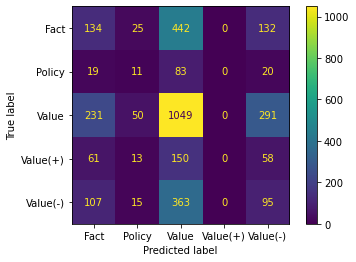

In [17]:
import sklearn.metrics as metrics
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

sgd_model = SGDClassifier(random_state = 0)
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={}, cv=5, scoring="accuracy", verbose = 1)
sgd_gs.fit(X_train, y_train)
y_pred = sgd_gs.predict(X_test)

print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_gs.classes_)
disp.plot()
plt.show()


## Using model trained on the articles dataset

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy score: 0.35891310839056434


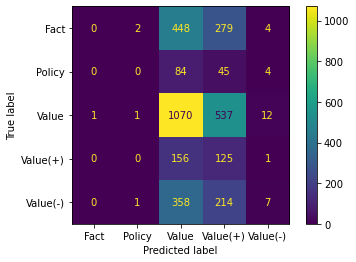

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

X_articles, y_articles = generate_sets(model_articles)

X_train, X_test, y_train, y_test = train_test_split(X_articles, y_articles, test_size = 0.20, random_state = 0, stratify=y_articles)


sgd_model = SGDClassifier()
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={}, cv=5, scoring="accuracy", verbose = 1)
sgd_gs.fit(X_train, y_train)
y_pred = sgd_gs.predict(X_test)
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_gs.classes_)
disp.plot()
plt.show()



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy score: 0.48074051955807706


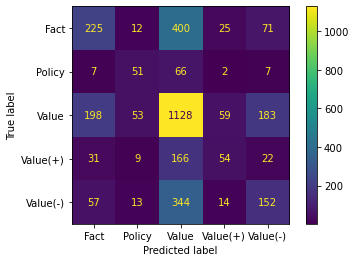

In [12]:
X, y = generate_sets(model_skip_s100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y_articles)


sgd_model = SGDClassifier()
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={}, cv=5, scoring="accuracy", verbose = 1)
sgd_gs.fit(X_train, y_train)
y_pred = sgd_gs.predict(X_test)
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_gs.classes_)
disp.plot()
plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy score: 0.47058823529411764


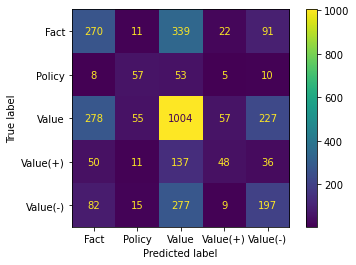

In [13]:
X, y = generate_sets(ft_skip_s100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y_articles)


sgd_model = SGDClassifier()
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={}, cv=5, scoring="accuracy", verbose = 1)
sgd_gs.fit(X_train, y_train)
y_pred = sgd_gs.predict(X_test)
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_gs.classes_)
disp.plot()
plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy score: 0.479247536578083


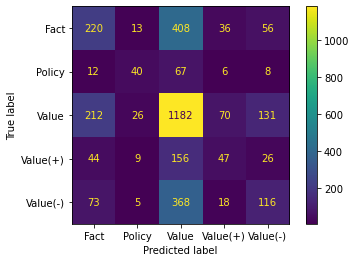

In [14]:
X, y = generate_sets(model_cbow_s100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y_articles)


sgd_model = SGDClassifier()
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={}, cv=5, scoring="accuracy", verbose = 1)
sgd_gs.fit(X_train, y_train)
y_pred = sgd_gs.predict(X_test)
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_gs.classes_)
disp.plot()
plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy score: 0.4720812182741117


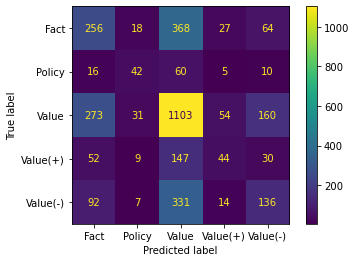

In [15]:
X, y = generate_sets(ft_model_cbow_s100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y_articles)


sgd_model = SGDClassifier()
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={}, cv=5, scoring="accuracy", verbose = 1)
sgd_gs.fit(X_train, y_train)
y_pred = sgd_gs.predict(X_test)
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_gs.classes_)
disp.plot()
plt.show()
